Bachelor thesis - 7337876 - University of Cologne - A spatio-temporal analysis of usage patterns in free-floating shared mobility


# Clustering Trip Types

This notebook contains the identification of trip types. Following steps are performed:
* Feature selection
* Feature scaling and transformation
* Clustering of trip types via k-means
* Evaluation of clustering (select k)
* Interpretation and visualization of cluster results
* Distribution of identified trip types among mobility modes

### Imports

In [1]:
import pandas as pd
import glob

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

from pyclustertend import hopkins

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, normalize

from sklearn.cluster import KMeans

from sklearn import metrics
from sklearn.metrics import silhouette_score, pairwise_distances, davies_bouldin_score

from sklearn.manifold import TSNE

import time

### Load Data

In [2]:
# load monthly data of mode based on selected months
def load_data(mode, months):
    first_read = True
    
    for month in months:
        data_month = pd.concat([pd.read_csv(file) for file in glob.glob('Data/Modes/data_supplemented_{}_{}.csv'.format(mode, month))], ignore_index = True)
        if (first_read):
            data_full = data_month
            first_read = False
        else:
            data_full = pd.concat([data_full, data_month], ignore_index=True)
    
    return data_full

# load full data of mode
def load_data_mode_full(mode):
    data_mode_full = pd.read_csv('Data/Modes/data_supplemented_full_{}.csv'.format(mode))
    
    return data_mode_full

In [3]:
# define months for data loading (YYYYMM)
months = ['201911', '201912', '202001', '202002']

#load data by months
load_monthly_data = False

if (load_monthly_data):
    data_car = load_data('car', months)
    data_bicycle = load_data('bicycle', months)
    data_scooter = load_data('scooter', months)
    data_full = pd.concat([data_car, data_bicycle, data_scooter], ignore_index=True)

In [4]:
# read in desired data
# set True if full data set load is desired
load_full_data = True

if (load_full_data):
    data_car = load_data_mode_full('car')
    data_bicycle = load_data_mode_full('bicycle')
    data_scooter = load_data_mode_full('scooter')
    data_full = pd.concat([data_car, data_bicycle, data_scooter], ignore_index=True)

### Feature selection

In [5]:
# select features
# to run on sample set True otherwise run on whole data set
if (False):
    dfa = data_full[['id','vehicleType','dist_center_start','dist_center_end', 'duration', 'hour', 'weekday', 'weekend']].copy()
    df = dfa.sample(n=70000, random_state=1).copy()
else:
    df = data_full[['id','vehicleType','dist_center_start','dist_center_end', 'duration', 'hour', 'weekday', 'weekend']].copy()

# convert duration into minutes
df['duration'] = df['duration'] / 60

# create cyclical hour feature
df['sin_hour'] = np.sin(2*np.pi*df.hour / 24)
df['cos_hour'] = np.cos(2*np.pi*df.hour / 24)

# create cyclical weekday feature
if (True):
    df['sin_weekday'] = np.sin(2*np.pi*df.weekday / 7)
    df['cos_weekday'] = np.cos(2*np.pi*df.weekday / 7)

# create cyclical weekday feature with workday/weekend gap of 1
if (False):
    df_gap = df[['weekday']].copy()
    df_gap.loc[df_gap['weekday'] > 4, 'weekday'] = df_gap.weekday+1

    df['sin_weekday'] = np.sin(2*np.pi*df_gap.weekday / 9)
    df['cos_weekday'] = np.cos(2*np.pi*df_gap.weekday / 9)

df

,id,vehicleType,dist_center_start,dist_center_end,duration,hour,weekday,weekend,sin_hour,cos_hour,sin_weekday,cos_weekday
0,ZnJlZWZsb2F0OjpjYXIyZ286OldNRTQ1MzM0MjFLMzE5MTQy,car,5055,4787,9.916667,13,0,0,-0.258819,-0.965926,0.000000,1.000000
1,ZnJlZWZsb2F0OjpjYXIyZ286OldNRTQ1MzM0MjFLMzIxNTM2,car,486,948,19.950000,13,0,0,-0.258819,-0.965926,0.000000,1.000000
2,ZnJlZWZsb2F0OjpjYXIyZ286OldNRTQ1MzM0MjFLMzcyNDA3,car,2049,4820,19.950000,13,0,0,-0.258819,-0.965926,0.000000,1.000000
3,ZnJlZWZsb2F0OjpjYXIyZ286OldNRTQ1MzM0MjFLMjkwNTc5,car,2943,3727,24.933333,13,0,0,-0.258819,-0.965926,0.000000,1.000000
4,ZnJlZWZsb2F0OjpjYXIyZ286OldNRTQ1MzM0MjFLMjkzNjQy,car,5268,2697,24.933333,13,0,0,-0.258819,-0.965926,0.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
404858,YmlrZTo6dGllcjo6YTFlMmYzZjEtNjkyZS00NjA4LWE5YT...,scooter,179,382,10.000000,23,5,1,-0.258819,0.965926,-0.974928,-0.222521
404859,YmlrZTo6dGllcjo6OGUxYjAwNDUtMDY3NS00Mzc4LTk3Yz...,scooter,3602,4204,15.033333,23,5,1,-0.258819,0.965926,-0.974928,-0.222521
404860,YmlrZTo6dGllcjo6ZGE1NmNkMDgtN2Q5ZS00YzE0LWI2OT...,scooter,2007,3149,15.033333,23,5,1,-0.258819,0.965926,-0.974928,-0.222521
404861,YmlrZTo6dGllcjo6NzRlY2JjZTYtZWQ3Yi00ZGY3LWJmMG...,scooter,2801,2958,5.000000,23,5,1,-0.258819,0.965926,-0.974928,-0.222521


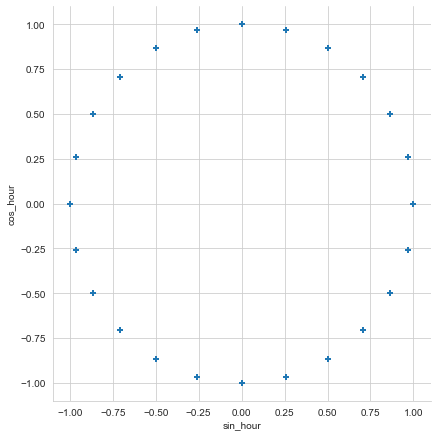

In [6]:
# plot features to visually observe structure of data
g = sns.relplot(x="sin_hour", y="cos_hour", kind="scatter", data=df, marker='+', height=6, aspect=1)

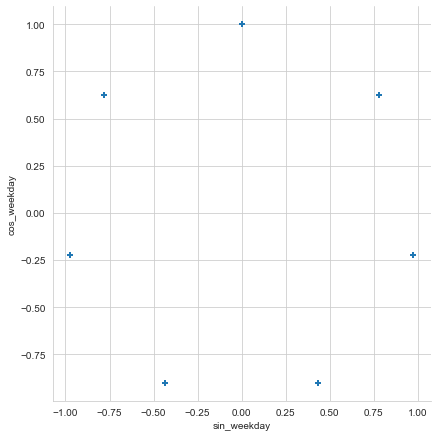

In [7]:
# plot features to visually observe structure of data
g = sns.relplot(x="sin_weekday", y="cos_weekday", kind="scatter", data=df, marker='+', height=6, aspect=1)

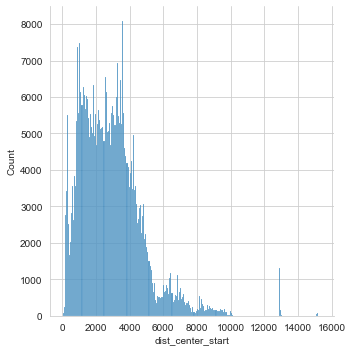

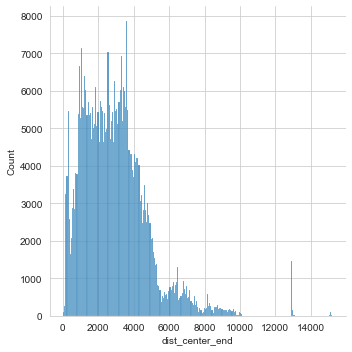

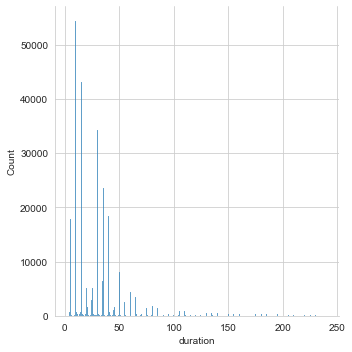

In [8]:
# univariate distribution of numeric variables
for column in df[['dist_center_start','dist_center_end', 'duration']].columns:
    sns.displot(df, x=column)

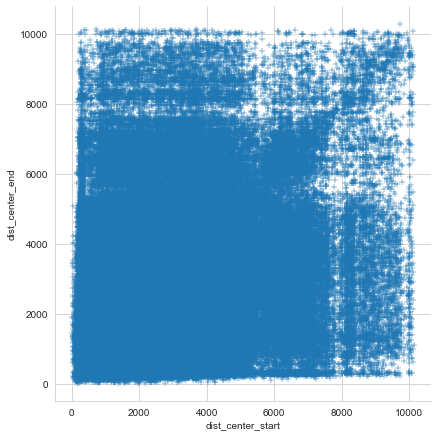

In [9]:
# remove extreme outliers due to sensibility of k-means regarding outliers
# has to be considered that trips outside the operation area or to and from isolated operation areas (e.g. airport) are removed
df = df[(df['dist_center_start']<11000)&(df['dist_center_end']<11000)].reset_index(drop=True)

# plot result
g = sns.relplot(x="dist_center_start", y="dist_center_end", kind="scatter", data=df, marker='+', height=6, aspect=1)

### Feature scaling

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'dist_center_start'),
  Text(1, 0, 'dist_center_end'),
  Text(2, 0, 'duration'),
  Text(3, 0, 'hour'),
  Text(4, 0, 'weekday'),
  Text(5, 0, 'weekend'),
  Text(6, 0, 'sin_hour'),
  Text(7, 0, 'cos_hour'),
  Text(8, 0, 'sin_weekday'),
  Text(9, 0, 'cos_weekday')])

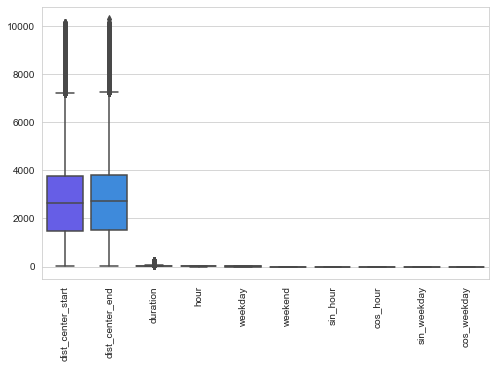

In [10]:
# look at feature scale
plt.figure(figsize=(8,5))
sns.boxplot(data=df, palette='rainbow')
plt.xticks(rotation=90)

In [11]:
# normalize features to get same range as sin and cos values
dfnorm = df[['dist_center_start','dist_center_end', 'duration', 'weekend']].copy()

# column names
names = dfnorm.columns
# create scaler object
scaler = StandardScaler()
# fit data on scaler object
dfnorm = scaler.fit_transform(dfnorm)
dfnorm = pd.DataFrame(dfnorm, columns=names)
# normalize data
dfnorm = normalize(dfnorm) 
  
# Converting the numpy array into a pandas DataFrame 
normalized_df = pd.DataFrame(dfnorm, columns=names) 

scaled_df = df[['sin_hour','cos_hour','sin_weekday','cos_weekday']].copy()
scaled_df = pd.concat([scaled_df, normalized_df], axis=1)
scaled_df

# assign weight to variables to compensate for double appearance of time related features
feature_weight = 1.5
feature_weight2 = 1.8

scaled_df['duration'] = scaled_df['duration'] * feature_weight2
scaled_df['dist_center_start'] = scaled_df['dist_center_start'] * feature_weight
scaled_df['dist_center_end'] = scaled_df['dist_center_end'] * feature_weight

scaled_df['sin_weekday'] = scaled_df['sin_weekday'] / 1.5
scaled_df['cos_weekday'] = scaled_df['cos_weekday'] / 1.5

scaled_df['weekend'] = scaled_df['weekend'] / 1.5

# square std to check variance of features
scaled_df.std()*scaled_df.std()

sin_hour             0.513469
cos_hour             0.384401
sin_weekday          0.223663
cos_weekday          0.218842
dist_center_start    0.548566
dist_center_end      0.551122
duration             0.510852
weekend              0.147749
dtype: float64

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 [Text(0, 0, 'sin_hour'),
  Text(1, 0, 'cos_hour'),
  Text(2, 0, 'sin_weekday'),
  Text(3, 0, 'cos_weekday'),
  Text(4, 0, 'dist_center_start'),
  Text(5, 0, 'dist_center_end'),
  Text(6, 0, 'duration'),
  Text(7, 0, 'weekend')])

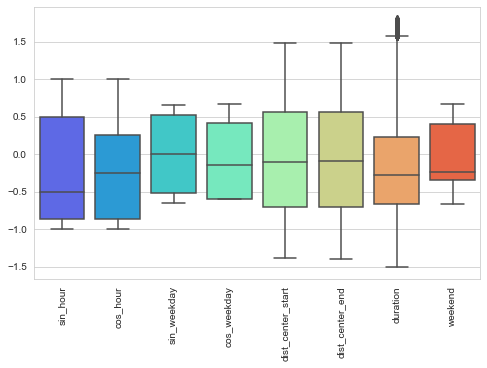

In [12]:
# visualize scaled features
plt.figure(figsize=(8,5))
sns.boxplot(data=scaled_df, palette='rainbow')
plt.xticks(rotation=90)

### Cluster tendency

In [22]:
# calculate hopkins statistics on subset (5% of data)
subset5perc = int(len(scaled_df) * 0.05)
1-hopkins(scaled_df, subset5perc)

0.947365067182592

### Clustering trip types via k-means 

#### Parameter selection / clustering performance evaluation

In [15]:
# run k-means multiple times to identify "optimal" k

# with-in cluster sum of squares
wcss=[]

# silhouette coefficients
silhouette_coefficients = []

# calinski_harabasz_score
calinski_harabasz_scores = []

# davies_bouldin_score
davies_bouldin_scores = []

# select range max value for for-loop
max_num_cluster = 30

# run loop
for i in range (2,max_num_cluster):   
    start = time.time()
    print(i)
    
    kmeans = KMeans(n_clusters=i, n_init=20)
    kmeans.fit(scaled_df)
    
    wcss.append(kmeans.inertia_)
    print('inertia: ', kmeans.inertia_)
        
    score = silhouette_score(scaled_df, kmeans.labels_)
    silhouette_coefficients.append(score)
    print('silhouette: ',score)
    
    score_cal = metrics.calinski_harabasz_score(scaled_df, kmeans.labels_)
    calinski_harabasz_scores.append(score_cal)
    print('calinski harabasz: ',score_cal)
    
    score_db = davies_bouldin_score(scaled_df, kmeans.labels_)
    davies_bouldin_scores.append(score_db)
    print('davies bouldin: ',score_db)

    end = time.time()
    print(end - start)

2
inertia:  1020597.7912438184
silhouette:  0.17365566052454354
calinski harabasz:  88104.86493394928
davies bouldin:  2.1090100057294605
3453.2009797096252
3
inertia:  913063.7236747855
silhouette:  0.16621980136613365
calinski harabasz:  72890.88560031676
davies bouldin:  2.028075938596943
2468.070759534836
4
inertia:  826442.2241729146
silhouette:  0.15498184416630628
calinski harabasz:  67718.53435646281
davies bouldin:  1.9136938100563963
2956.496991634369
5
inertia:  760841.6845937768
silhouette:  0.15912374152868214
calinski harabasz:  63824.83257591992
davies bouldin:  1.8660152447307077
2882.625198364258
6
inertia:  711128.1375586682
silhouette:  0.16351938296228832
calinski harabasz:  60244.197153914596
davies bouldin:  1.768434493704248
2576.080969810486
7
inertia:  669148.1072118955
silhouette:  0.16479870165199376
calinski harabasz:  57552.53490939873
davies bouldin:  1.7009714872479016
2508.6699438095093
8
inertia:  634226.1987389014
silhouette:  0.17294701912588556
calin

#### Elbow method

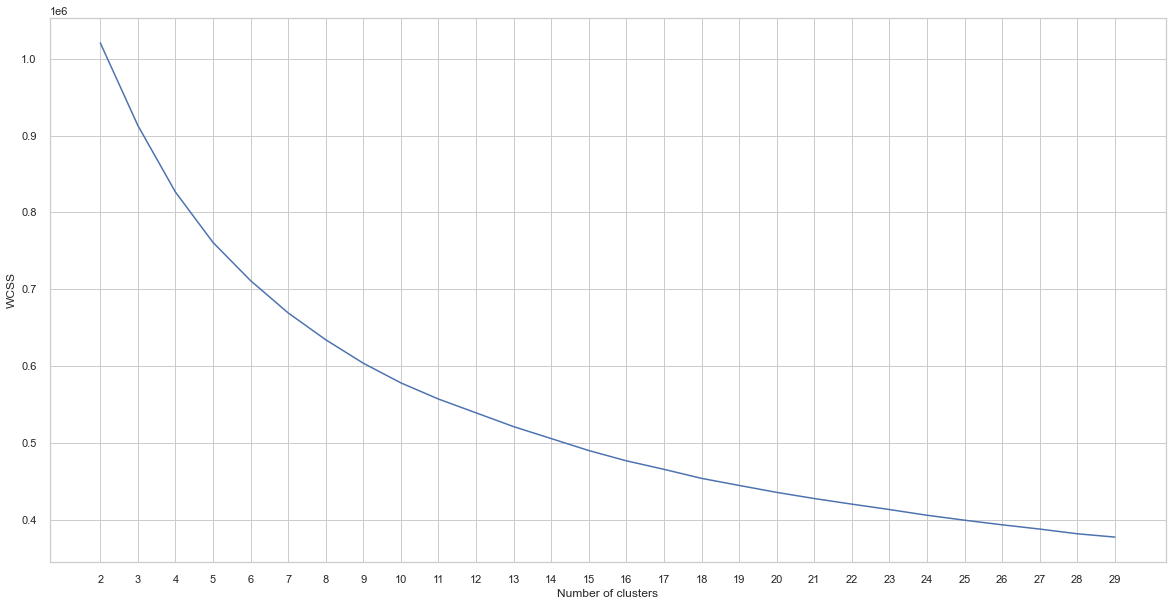

In [57]:
# plot wcss for each k
fig = plt.figure(figsize=(20, 10))
plt.plot(range(2, max_num_cluster), wcss)
plt.xticks(range(2, max_num_cluster))
plt.xlabel("Number of clusters")
plt.ylabel("WCSS")
plt.show()
#fig.savefig('elbowPlot2.png', dpi=fig.dpi)

#### Silhouette coefficient

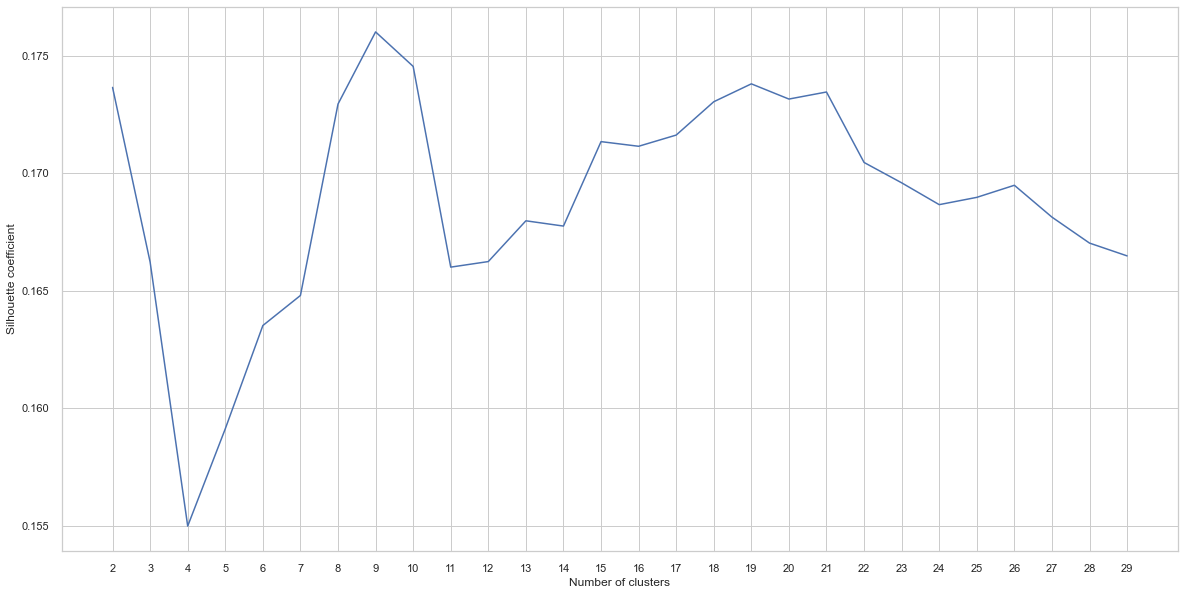

In [55]:
# plot silhouette coefficients for each k
fig = plt.figure(figsize=(20, 10))
plt.plot(range(2, max_num_cluster), silhouette_coefficients)
plt.xticks(range(2, max_num_cluster))
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette coefficient")
plt.show()
#fig.savefig('silhouetteScore2.png', dpi=fig.dpi)

#### Calinski Harabasz score

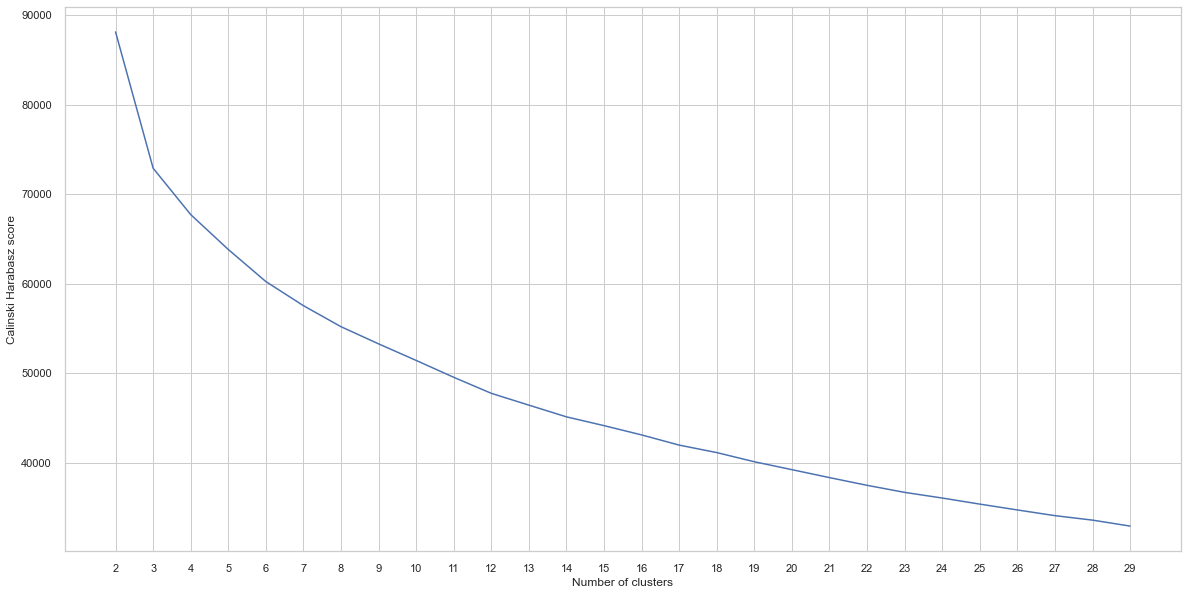

In [53]:
# plot Calinski Harabasz score for each k
fig = plt.figure(figsize=(20, 10))
plt.plot(range(2, max_num_cluster), calinski_harabasz_scores)
plt.xticks(range(2, max_num_cluster))
plt.xlabel("Number of clusters")
plt.ylabel("Calinski Harabasz score")
plt.show()
#fig.savefig('calinskiHarabaszScore2.png', dpi=fig.dpi)

#### Davies Bouldin index

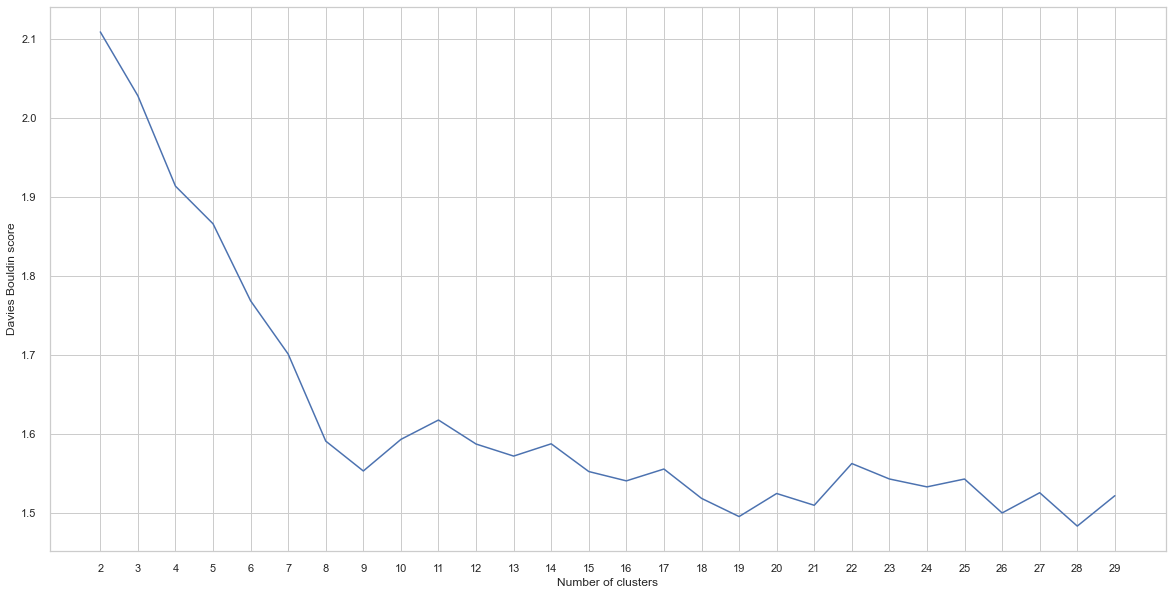

In [51]:
# plot Davies Bouldin scores for each k
fig = plt.figure(figsize=(20, 10))
plt.plot(range(2, max_num_cluster), davies_bouldin_scores)
plt.xticks(range(2, max_num_cluster))
plt.xlabel("Number of clusters")
plt.ylabel("Davies Bouldin score")
plt.show()
#fig.savefig('daviesBouldinScore2.png', dpi=fig.dpi)

#### K-means with selected parameter

In [14]:
# cluster data for the chosen number of clusters
k = 19

# run k-means
kmeans = KMeans(n_clusters=k, n_init=100, max_iter=5000, random_state=0).fit(scaled_df)

# create dataframe of trips with cluster column
clustered_data = df.copy()
cluster_labels = kmeans.fit_predict(scaled_df)
clustered_data['cluster'] = cluster_labels
scaled_df['cluster'] = cluster_labels

clustered_data.head()

,id,vehicleType,dist_center_start,dist_center_end,duration,hour,weekday,weekend,sin_hour,cos_hour,sin_weekday,cos_weekday,cluster
0,ZnJlZWZsb2F0OjpjYXIyZ286OldNRTQ1MzM0MjFLMzE5MTQy,car,5055,4787,9.916667,13,0,0,-0.258819,-0.965926,0.0,1.0,12
1,ZnJlZWZsb2F0OjpjYXIyZ286OldNRTQ1MzM0MjFLMzIxNTM2,car,486,948,19.950000,13,0,0,-0.258819,-0.965926,0.0,1.0,10
2,ZnJlZWZsb2F0OjpjYXIyZ286OldNRTQ1MzM0MjFLMzcyNDA3,car,2049,4820,19.950000,13,0,0,-0.258819,-0.965926,0.0,1.0,18
3,ZnJlZWZsb2F0OjpjYXIyZ286OldNRTQ1MzM0MjFLMjkwNTc5,car,2943,3727,24.933333,13,0,0,-0.258819,-0.965926,0.0,1.0,8
4,ZnJlZWZsb2F0OjpjYXIyZ286OldNRTQ1MzM0MjFLMjkzNjQy,car,5268,2697,24.933333,13,0,0,-0.258819,-0.965926,0.0,1.0,12


### Interpretation of results

#### Cluster cardinality

<AxesSubplot:xlabel='cluster', ylabel='count'>

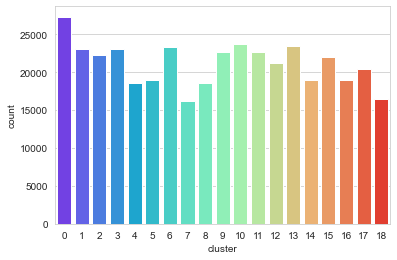

In [15]:
# show cardinality (sum of instances) of clusters
sns.countplot(x="cluster", data=clustered_data, palette='rainbow')

#### Attribute table

In [31]:
# create an attribute table to interpret cluster results
# create table with cardinality columns
cluster_cardinality = clustered_data.groupby(['cluster']).count().iloc[:,:2].copy()
cluster_cardinality.columns = ['cardinality', 'proportion']
instances = len(clustered_data)
cluster_cardinality['proportion'] = cluster_cardinality['cardinality'] / instances * 100
interpret_df = cluster_cardinality

# create table with means of numeric features
means = clustered_data[['dist_center_start', 'dist_center_end', 'duration', 'weekend', 'cluster']].copy()
means = means.groupby(['cluster']).mean()

# merge 2 dataframes
interpret_df = interpret_df.join(means)

# create table with percentages for each categorical value
time_df = clustered_data[['weekday','hour','cluster']].copy()

dayOfWeek={0:'0 Monday', 1:'1 Tuesday', 2:'2 Wednesday', 3:'3 Thursday', 4:'4 Friday', 5:'5 Saturday', 6:'6 Sunday'}
time_df['weekday'] = time_df['weekday'].map(dayOfWeek)
time_df = time_df.join(pd.get_dummies(time_df['weekday']))
time_df = time_df.drop(['weekday'],axis=1)

time_df = time_df.join(pd.get_dummies(time_df['hour']))
time_df = time_df.drop(['hour'],axis=1)

time_df = time_df.groupby(['cluster']).sum()

count = clustered_data.groupby(['cluster'])['id'].count().copy()

for i in count.index:
    for col in time_df.columns:
        time_df[col][i] = time_df[col][i] / count[i] * 100

# merge dataframes
interpret_df = interpret_df.join(time_df)

interpret_df['night 0-5'] = interpret_df[0] + interpret_df[1] + interpret_df[2] + interpret_df[3] + interpret_df[4] + interpret_df[5]
interpret_df['morning 6-11'] = interpret_df[6] + interpret_df[7] + interpret_df[8] + interpret_df[9] + interpret_df[10] + interpret_df[11]
interpret_df['midday 12-17'] = interpret_df[12] + interpret_df[13] + interpret_df[14] + interpret_df[15] + interpret_df[16] + interpret_df[17]
interpret_df['evening 18-23'] = interpret_df[18] + interpret_df[19] + interpret_df[20] + interpret_df[21] + interpret_df[22] + interpret_df[23]

interpret_df['Hours 0-2'] = interpret_df[0] + interpret_df[1] + interpret_df[2] 
interpret_df['Hours 3-5'] = interpret_df[3] + interpret_df[4] + interpret_df[5]
interpret_df['Hours 6-8'] = interpret_df[6] + interpret_df[7] + interpret_df[8] 
interpret_df['Hours 9-11'] =interpret_df[9] + interpret_df[10] + interpret_df[11]
interpret_df['Hours 12-14'] = interpret_df[12] + interpret_df[13] + interpret_df[14] 
interpret_df['Hours 15-17'] = interpret_df[15] + interpret_df[16] + interpret_df[17]
interpret_df['Hours 18-20'] = interpret_df[18] + interpret_df[19] + interpret_df[20]
interpret_df['Hours 21-23'] = interpret_df[21] + interpret_df[22] + interpret_df[23]

# save files set True
if (False):
    interpret_df.T.round(2).to_excel("Final-19-15-18-15-15-InterpretClustersT.xlsx")  
    interpret_df.round(2).to_excel("Final-19-15-18-15-15-InterpretClusters.xlsx")  
    interpret_df.round(2).T.to_csv('finalclustersT.csv', index=False)
    interpret_df.round(2).to_csv('finalclusters.csv', index=False)
    scaled_df.to_csv('scaledDataWithFinalClusters.csv', index=False)

# display whole dataframe
pd.set_option("display.max_rows", None, "display.max_columns", None)
interpret_df.T.round(2)

cluster,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
cardinality,27318.00,22999.00,22290.00,23068.00,18561.00,18926.00,23281.00,16184.00,18584.00,22666.00,23661.00,22659.00,21268.00,23408.00,18971.00,22010.00,18973.00,20365.00,16430.00
proportion,6.80,5.73,5.55,5.74,4.62,4.71,5.80,4.03,4.63,5.64,5.89,5.64,5.30,5.83,4.72,5.48,4.72,5.07,4.09
dist_center_start,1550.10,1802.69,4797.64,1579.22,4151.32,3891.78,1685.93,3022.82,3298.60,1707.28,1512.27,2840.98,4945.25,1474.89,4265.05,4491.45,2310.71,4094.21,1656.26
dist_center_end,1534.62,1677.94,1732.71,4495.98,3839.32,4107.89,1847.94,2955.76,3338.30,1820.25,1589.20,2930.79,4919.94,1532.61,1328.05,4532.13,2763.38,4177.13,4821.00
duration,15.36,20.80,33.93,31.22,27.32,27.81,20.89,92.78,12.30,15.86,17.43,85.36,33.69,17.47,31.30,24.24,18.50,18.40,32.80
weekend,0.02,1.00,0.06,0.05,1.00,1.00,1.00,0.16,0.00,0.00,0.00,0.19,0.01,0.00,0.08,0.04,0.98,0.01,0.05
0 Monday,20.69,0.17,15.08,17.50,0.00,0.04,0.00,15.21,18.29,13.16,40.22,15.11,18.17,0.00,17.88,17.38,0.90,18.50,17.66
1 Tuesday,22.83,0.00,15.59,16.76,0.00,0.00,0.00,16.62,19.78,15.08,40.08,14.91,19.56,0.00,17.68,19.82,0.00,18.61,18.49
2 Wednesday,19.55,0.00,17.81,18.49,0.00,0.00,0.00,15.51,20.11,20.03,19.70,14.26,19.91,12.17,17.31,18.56,0.00,19.74,18.49
3 Thursday,18.09,0.00,18.21,18.48,0.00,0.00,0.00,17.94,20.35,21.06,0.00,15.19,19.34,37.57,19.07,20.81,0.00,18.44,19.65


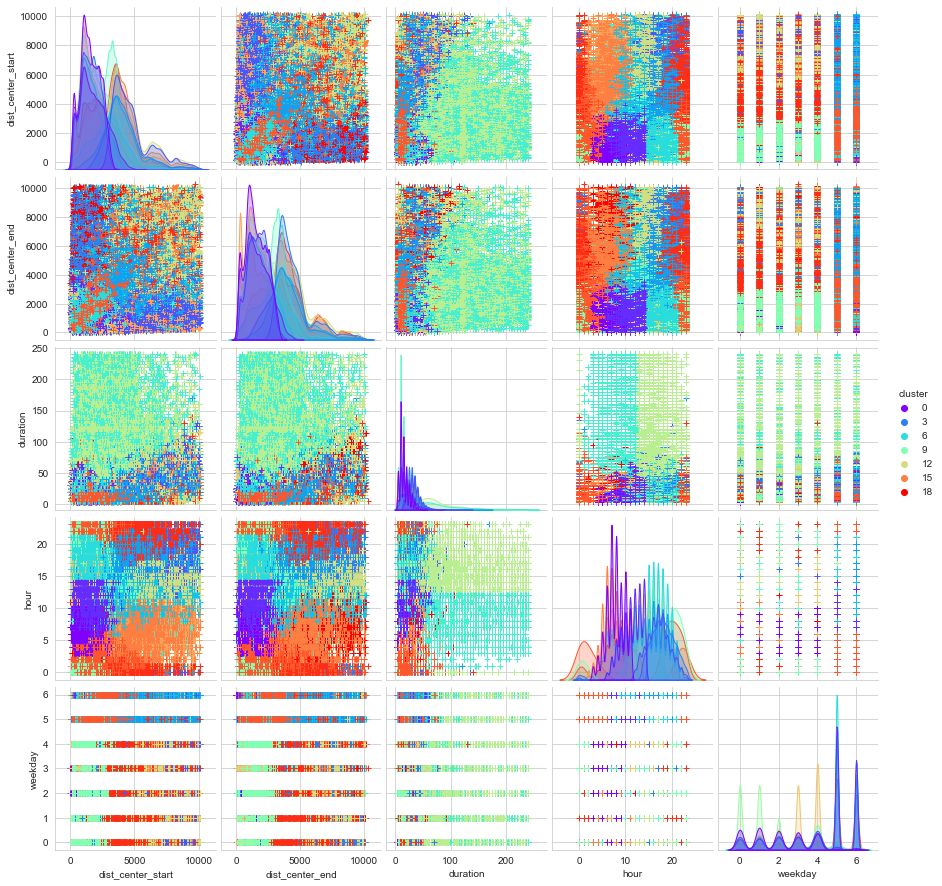

In [17]:
# show pairwise relation
sns.pairplot(clustered_data[['dist_center_start','dist_center_end','duration','hour','weekday','cluster']], hue="cluster", plot_kws=dict(marker="+", linewidth=1), palette='rainbow')

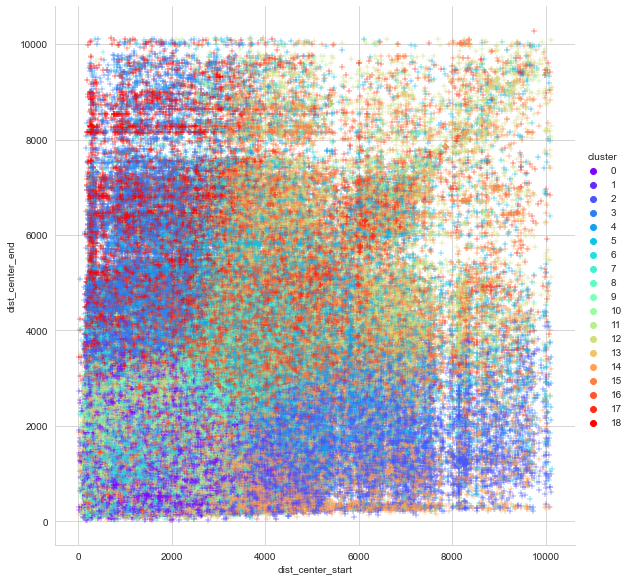

In [18]:
# plot cluster results for two desired features
g = sns.relplot(x="dist_center_start", y="dist_center_end", kind="scatter", data=clustered_data, marker='+', hue='cluster', palette='rainbow', legend='full', height=8, aspect=1)

#### Cluster visualization with t-SNE

In [38]:
# load clustered data
tSNE_data = pd.read_csv('scaledDataWithFinalClusters.csv')

# create new labeling for trip type for explanation purposes in the text
trip_type_transform = {0:2, 1:5, 2:10, 3:8, 4:14, 5:15, 6:6, 7:18, 8:17, 9:1, 10:3, 11:19, 12:13, 13:4, 14:9, 15:12, 16:16, 17:11, 18:7}
tSNE_data['Type'] = tSNE_data['cluster'].map(trip_type_transform)
tSNE_data.head()

,sin_hour,cos_hour,sin_weekday,cos_weekday,dist_center_start,dist_center_end,duration,weekend,cluster,Type
0,-0.258819,-0.965926,0.0,0.666667,0.988174,0.851393,-0.668495,-0.216962,12,13
1,-0.258819,-0.965926,0.0,0.666667,-1.075801,-0.874320,-0.334291,-0.222495,10,3
2,-0.258819,-0.965926,0.0,0.666667,-0.484998,1.192790,-0.448967,-0.298820,18,7
3,-0.258819,-0.965926,0.0,0.666667,0.109899,0.900670,-0.368534,-0.513020,8,17
4,-0.258819,-0.965926,0.0,0.666667,1.356669,-0.095530,-0.195215,-0.271751,12,13


In [68]:
# choose sample for tSNE calculation
subset10perc = int(len(scaled_df) * 0.1)

TSNE_data2 = tSNE_data.copy()
sampleTSNE2 = TSNE_data2.sample(n=subset10perc, random_state=1).reset_index()

# multiple perplexity parameter values and iteration numbers were compared
X2 = sampleTSNE2.iloc[:,1:-2]
tsne2 = TSNE(n_components=2, perplexity=50.0, n_iter=5000, verbose=1).fit_transform(X2)
tsne2

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 40162 samples in 0.108s...
[t-SNE] Computed neighbors for 40162 samples in 5.908s...
[t-SNE] Computed conditional probabilities for sample 1000 / 40162
[t-SNE] Computed conditional probabilities for sample 2000 / 40162
[t-SNE] Computed conditional probabilities for sample 3000 / 40162
[t-SNE] Computed conditional probabilities for sample 4000 / 40162
[t-SNE] Computed conditional probabilities for sample 5000 / 40162
[t-SNE] Computed conditional probabilities for sample 6000 / 40162
[t-SNE] Computed conditional probabilities for sample 7000 / 40162
[t-SNE] Computed conditional probabilities for sample 8000 / 40162
[t-SNE] Computed conditional probabilities for sample 9000 / 40162
[t-SNE] Computed conditional probabilities for sample 10000 / 40162
[t-SNE] Computed conditional probabilities for sample 11000 / 40162
[t-SNE] Computed conditional probabilities for sample 12000 / 40162
[t-SNE] Computed conditional probabilities for sa

array([[  88.12356 ,  -81.198296],
       [ -53.870342,  138.55307 ],
       [ -65.67079 ,  111.25337 ],
       ...,
       [   2.282673,  -81.490234],
       [ -62.401814,   90.63231 ],
       [  38.19939 , -106.84545 ]], dtype=float32)

In [107]:
# assign clusters to tSNE computed results 
type_label_tsne2 = sampleTSNE2['Type']
tsne_type2 = pd.DataFrame(tsne2)
tsne_type2['Type'] = type_label_tsne2
tsne_type2.columns = ['tsne1','tsne2','trip type']
tsne_type2.head()

,tsne1,tsne2,trip type
0,88.123558,-81.198296,8
1,-53.870342,138.553070,16
2,-65.670792,111.253372,14
3,63.266171,-56.955940,10
4,83.040398,-47.777466,11


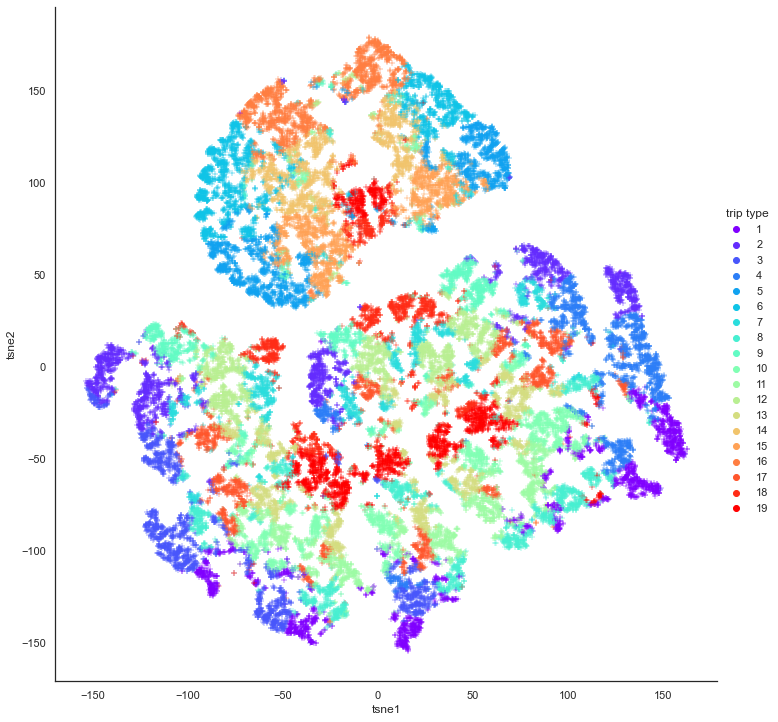

In [112]:
# plot tSNE results
sns.set_theme(style="white")

fig = sns.relplot(x="tsne1", y="tsne2", kind="scatter", data=tsne_type2, hue='trip type', marker='+', palette ='rainbow', legend="full", height=10, aspect=1)

#fig.savefig('tSNE.png')

In [54]:
# number of instances used for tSNE
subset10perc

40162

### Distribution of trip types within mobility modes

In [55]:
# show distribution of each mobility mode for the identified trip types
def create_distribution_overview(mode):
    
    distribution = clustered_data[clustered_data['vehicleType']==mode]

    distribution = distribution.groupby(['Type']).count().copy()
    trip_volume = len(clustered_data[clustered_data['vehicleType']==mode])
    distribution['Distribution {} [%]'.format(mode)] = distribution['id'] / trip_volume *100

    return distribution[['Distribution {} [%]'.format(mode)]]

In [60]:
clustered_data['Type'] = clustered_data['cluster'].map(trip_type_transform)
car = create_distribution_overview('car')
bicycle = create_distribution_overview('bicycle')
scooter = create_distribution_overview('scooter')
df_distribution = car.merge(bicycle, how='left', on='Type')
df_distribution = df_distribution.merge(scooter, how='left', on='Type')
#df_distribution.round(2).to_csv('distributionTable.csv', index=False)

df_distribution

,Distribution car [%],Distribution bicycle [%],Distribution scooter [%]
Type,,,
1,3.044108,7.678130,9.964570
2,3.089499,10.403514,12.840100
3,2.836958,10.278028,10.587963
4,2.926503,8.772205,10.523680
5,4.008880,6.658562,8.660228
6,4.295258,6.203678,8.438976
7,6.100595,2.623427,0.730282
8,8.187772,3.423395,1.758805
9,6.902784,3.293988,1.048705
